
Successfully processed: 72 profiles
Exported: folder_names_list.txt and file_paths_list.txt


C:\Users\RReddy\AppData\Local\Temp\ipykernel_38492\17282897.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_tops))
C:\Users\RReddy\AppData\Local\Temp\ipykernel_38492\17282897.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


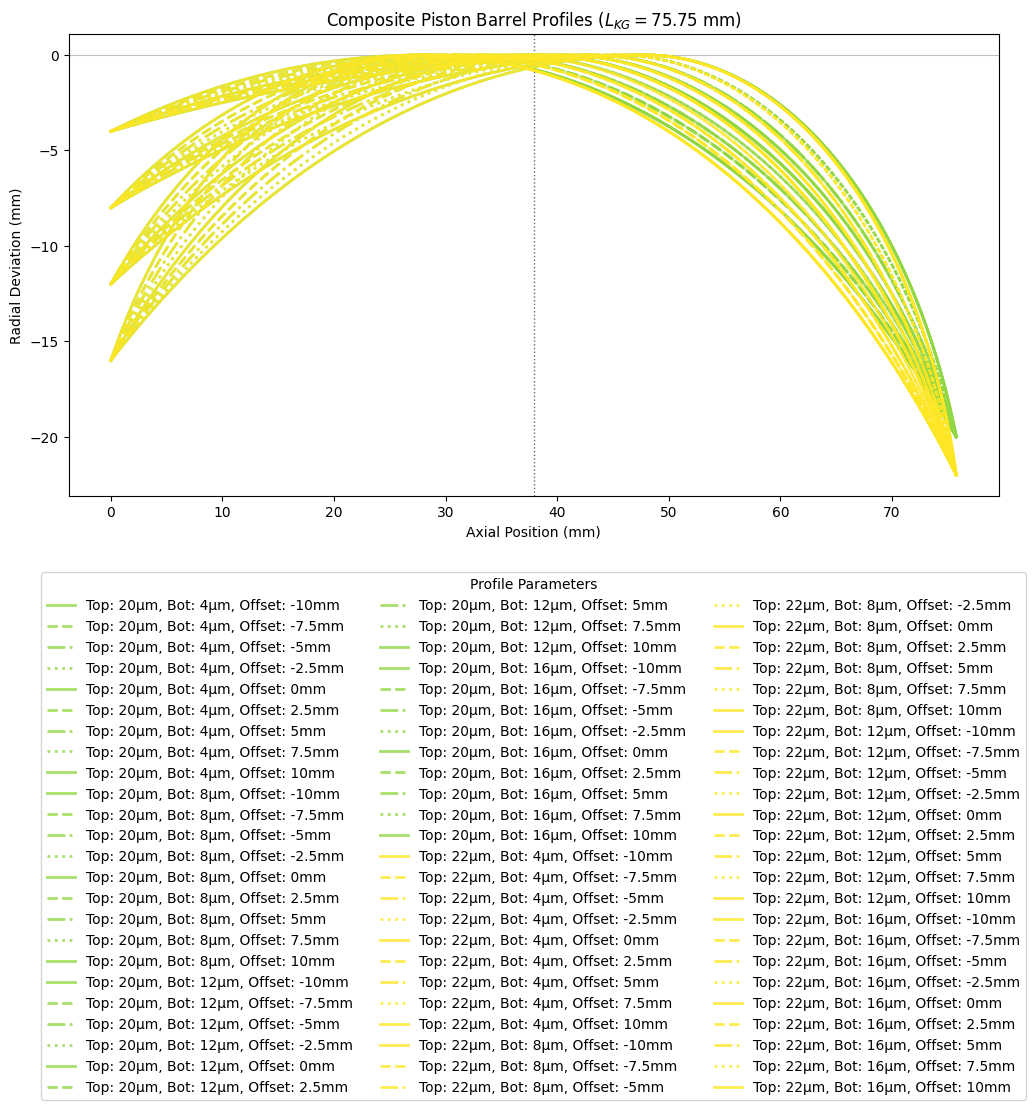

In [2]:
#!/usr/bin/env python3

"""
Composite Barrel Piston Profile - Batch Processing with TXT Export
Generates profiles and saves each to a .txt file, plus summary lists.
"""

import os
import numpy as np
import matplotlib.pyplot as plt

SCRIPT_DIR = os.getcwd()

def calculate_composite_profile(delta_top, delta_bot, l_s_P, l_KG, num_points=500):
    """
    Calculates a composite barrel profile.
    """
    midpoint = l_KG / 2.0
    peak_x = midpoint + l_s_P

    d_crown = np.abs(l_KG - peak_x)
    d_skirt = np.abs(0.0 - peak_x)

    # --- Top Arc ---
    if delta_top > 1e-9:
        R_top = (d_crown**2 + delta_top**2) / (2 * delta_top)
    else:
        R_top = np.inf

    # --- Bottom Arc ---
    if delta_bot > 1e-9:
        R_bot = (d_skirt**2 + delta_bot**2) / (2 * delta_bot)
    else:
        R_bot = np.inf

    x = np.linspace(0.0, l_KG, num_points)
    y = np.zeros_like(x)

    for i, xi in enumerate(x):
        d = np.abs(xi - peak_x)
        if xi >= peak_x:
            if np.isinf(R_top):
                y[i] = 0.0
            else:
                y[i] = -(R_top - np.sqrt(R_top**2 - d**2))
        else:
            if np.isinf(R_bot):
                y[i] = 0.0
            else:
                y[i] = -(R_bot - np.sqrt(R_bot**2 - d**2))

    return {
        "x": x, "y": y, "peak_x": peak_x,
        "R_top": R_top, "R_bot": R_bot,
        "delta_top": delta_top, "delta_bot": delta_bot, "l_s_P": l_s_P
    }

def save_profile_txt(data, filename):
    filepath = os.path.join(SCRIPT_DIR, filename)
    x = data['x']
    y = data['y']
    np.savetxt(filepath, np.column_stack([x, y]), fmt="%.6f", delimiter="\t")
    # print(f"Saved: {filename}")

def plot_batch_profiles(data_list, l_KG, unique_tops, unique_lsps):
    fig, ax = plt.subplots(figsize=(12, 6))
    midpoint = l_KG / 2.0
    colors = plt.cm.get_cmap('viridis', len(unique_tops))
    top_to_color = {v: colors(i) for i, v in enumerate(unique_tops)}
    style_opts = ['-', '--', '-.', ':']
    lsp_to_style = {v: style_opts[i % len(style_opts)] for i, v in enumerate(unique_lsps)}

    ax.axvline(midpoint, color='black', linestyle=':', linewidth=1, alpha=0.6)
    ax.axhline(0, color='gray', linewidth=0.8, alpha=0.5)

    for data in data_list:
        x, y = data['x'], data['y']
        d_top, d_bot, lsp = data['delta_top'], data['delta_bot'], data['l_s_P']
        color = top_to_color.get(d_top, 'black')
        style = lsp_to_style.get(lsp, '-')
        label = f"Top: {d_top:.0f}µm, Bot: {d_bot:.0f}µm, Offset: {lsp}mm"
        ax.plot(x, y, label=label, color=color, linestyle=style, linewidth=2, alpha=0.8)

    ax.set_xlabel('Axial Position (mm)')
    ax.set_ylabel('Radial Deviation (mm)')
    ax.set_title(f'Composite Piston Barrel Profiles ($L_{{KG}}={l_KG:.2f}$ mm)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, title="Profile Parameters")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    l_KG = 75.753

    # Study Parameters
    delta_top_first = (4, 8, 12, 14, 18)
    delta_bot_first = (4, 8, 12, 16)
    l_s_P_first     = (-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10)

    excluded_combos = {(dt, db, lsp) for dt in delta_top_first for db in delta_bot_first for lsp in l_s_P_first}

    delta_top_list = (4, 8, 12, 14, 18, 20, 22)
    delta_bot_list = (4, 8, 12, 16)
    l_s_P_list = (-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10)

    all_profiles = []
    # --- NEW LISTS FOR EXPORT ---
    folder_names = []
    file_paths = []
    processed = 0

    for d_top in delta_top_list:
        for d_bot in delta_bot_list:
            for lsp in l_s_P_list:
                
                if (d_top, d_bot, lsp) in excluded_combos:
                    continue

                processed += 1
                data = calculate_composite_profile(d_top, d_bot, lsp, l_KG)
                all_profiles.append(data)

                # 1. Base filename
                core_name = f"lsp_{lsp}_DC{d_bot}_case{d_top}"
                
                # 2. Generate the Folder Name entry (from Image 1)
                folder_entry = f"T60_2850rpm_350bar_100d_{core_name}"
                folder_names.append(folder_entry)
                
                # 3. Generate the File Path entry (from Image 2)
                path_entry = f"./input/{core_name}.txt"
                file_paths.append(path_entry)

                # 4. Save the actual profile data
                save_profile_txt(data, f"{core_name}.txt")

    # --- SAVE THE NEW SUMMARY FILES ---
    with open("folder_names_list.txt", "w") as f_out:
        f_out.write("\n".join(folder_names))
    
    with open("file_paths_list.txt", "w") as p_out:
        p_out.write("\n".join(file_paths))

    print(f"\nSuccessfully processed: {processed} profiles")
    print(f"Exported: folder_names_list.txt and file_paths_list.txt")

    if all_profiles:
        plot_batch_profiles(all_profiles, l_KG, delta_top_list, l_s_P_list)